# SINDy-PI Feature Overview

This notebook provides a simple overview of the basic functionality of SINDy-PI implemented in PySINDy, and is written by Alan Kaptanoglu and Kadierdan Kaheman. SINDy-PI is used to handle generic implicit ODEs of the form,
$$ \frac{d}{dt}\mathbf{x} = \mathbf{f}(\mathbf{x}, \dot{\mathbf{x}})$$
This is based off of the paper "Kaheman, K., Kutz, J. N., & Brunton, S. L. (2020). SINDy-PI: a robust algorithm for parallel implicit sparse identification of nonlinear dynamics. Proceedings of the Royal Society A, 476(2242), 20200279."

In [1]:
# Import libraries.
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps 
from pysindy.differentiation import FiniteDifference
import matplotlib.gridspec as gridspec
import numexpr as ne
from numpy import cos, sin
from pysindy.utils import enzyme, bacterial, pendulum_on_cart
import sympy as sp
from scipy.integrate import odeint

# For reproducibility
np.random.seed(100)

# Example to show library functionality
Below, we define custom libraries for x and x_dot, showing that the resulting full library and library names are a tensor product of the two independent libraries. Note that lambda x: '', is used to trick the code to generate the constant function 1 without generating repeated entries.

In [2]:
t = np.linspace(0, 1, 5)
x = np.ones((5, 2))

# Functions to be applied to the data x
functions = [lambda x: 1, lambda x : np.exp(x), lambda x,y : np.sin(x+y)]

# Functions to be applied to the data x_dot
x_dot_functions = [lambda x: 1, lambda x : x]

# Function names includes both the x and x_dot functions
function_names = [lambda x: '',
                  lambda x : 'exp(' + x + ')',
                  lambda x, y : 'sin(' + x + y + ')',
                  lambda x: '',
                  lambda x : x]
lib = ps.SINDyPILibrary(library_functions=functions,
                        x_dot_library_functions=x_dot_functions,
                        function_names=function_names, t=t,
                        ).fit(x)
lib.transform(x)
print(lib.get_feature_names())

['', 'exp(x0)', 'exp(x1)', 'sin(x0x1)', 'x0_dot', 'exp(x0)x0_dot', 'exp(x1)x0_dot', 'sin(x0x1)x0_dot', 'x1_dot', 'exp(x0)x1_dot', 'exp(x1)x1_dot', 'sin(x0x1)x1_dot']


### Solve 1D Michelson-Menten enzyme model as first demonstration
$$\dot{x} = 0.6 - \frac{1.5 x}{0.3 + x}$$

In [3]:
# define parameters
r = 1
dt = 0.01
T = 5
t = np.arange(0, T + dt, dt)
x0_train = [0.55]
x_train = odeint(enzyme, x0_train, t)

# Initialize custom SINDy library so that we can have x_dot inside it. Using the library
# Found in Equation A1 in the SINDy-PI paper
x_library_functions = [lambda x:1, lambda x:x, lambda x, y:x * y, lambda x:x ** 2, 
                       lambda x, y, z:x * y * z, lambda x, y: x * y ** 2, lambda x: x ** 3,
                       lambda x, y, z, w: x * y * z * w, lambda x, y, z:x * y * z ** 2,
                       lambda x, y:x * y ** 3, lambda x:x ** 4]
x_dot_library_functions = [lambda x:1, lambda x:x]
        
# library function names includes both the x_library_functions and x_dot_library_functions names
library_function_names = [lambda x:'', lambda x:x, lambda x, y: x + y, lambda x:x + x, 
                          lambda x, y, z:x + y + z, lambda x, y: x + y + y, lambda x: x + x + x,
                          lambda x, y, z, w: x + y + z + w, lambda x, y, z:x + y + z + z,
                          lambda x, y:x + y + y + y, lambda x:x + x + x + x,
                          lambda x:'', lambda x:x] 

# Need to pass time base to the library so can build the x_dot library from x
sindy_library = ps.SINDyPILibrary(library_functions=x_library_functions, 
                                  x_dot_library_functions=x_dot_library_functions,
                                  t=t[1:-1],
                                  function_names=library_function_names,
                                  )

# Use the SINDy-PI optimizer, which relies on CVXPY.
# Note that if LHS of the equation fits the data poorly, 
# CVXPY often returns failure.
sindy_opt = ps.SINDyPI(threshold=1e-7, tol=1e-10, 
                       thresholder="l1", max_iter=20000)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
model.print()

Solver failed on model  3 , setting coefs to zeros
Solver failed on model  9 , setting coefs to zeros
 = 5.000 x0 + 0.001 x0x0x0 + 1.666 x0_dot + 5.557 x0x0_dot
x0 = 0.200  + -0.333 x0_dot + -1.111 x0x0_dot
x0x0 = 0.198 x0 + 0.006 x0x0x0 + -0.338 x0x0_dot + -1.099 x0x0x0_dot
x0x0x0 = 0.000
x0x0x0x0 = -0.001  + 0.362 x0x0x0 + 0.041 x0x0_dot + -1.206 x0x0x0x0x0_dot
x0_dot = 0.600  + -3.000 x0 + -3.334 x0x0_dot
x0x0_dot = 0.180  + -0.899 x0 + -0.300 x0_dot
x0x0x0_dot = -0.001  + 0.177 x0 + -0.848 x0x0 + -0.030 x0x0x0 + -0.262 x0x0_dot
x0x0x0x0_dot = 0.003  + 0.001 x0 + -0.389 x0x0x0 + -0.249 x0x0x0x0 + -0.107 x0x0_dot
x0x0x0x0x0_dot = 0.000


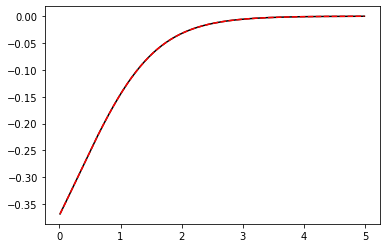

In [4]:
# Plot the fit of the derivative
x_dot_train = model.differentiate(x_train, t)
x_dot_train_pred = sindy_opt.Theta @ sindy_opt.coef_.T
plt.figure()
for i in range(r):
    plt.subplot(1, r, i + 1)
    plt.plot(t, x_dot_train[:, i], 'k')
    plt.plot(t[1:-1], x_dot_train_pred[:, 5], 'r--')

### Now we need to reformat all the feature strings for conversion into symbolic variables

In [5]:
features = model.get_feature_names()
features[0] = '1'
features_copy = list(np.copy(features))
nfeatures = len(features)
features_formatted = []
# Need to put multiplication between terms for sympy
for i in range(nfeatures):
    for j in range(r):
        # Overkill to make sure all the x0, x1, etc. get replaced
        temp_string = features[i].replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_string = temp_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_string = temp_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_string = temp_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        features[i] = temp_string
    features_formatted.append(temp_string)
features = features_copy
print(features)
print(features_formatted)
coefs = model.coefficients()
sym_features = [sp.symbols(feature) for feature in features]
sym_theta = [sp.symbols(feature) for feature in features]

['1', 'x0', 'x0x0', 'x0x0x0', 'x0x0x0x0', 'x0_dot', 'x0x0_dot', 'x0x0x0_dot', 'x0x0x0x0_dot', 'x0x0x0x0x0_dot']
['1', 'x0', 'x0 * x0', 'x0 * x0 * x0', 'x0 * x0 * x0 * x0', 'x0_dot', 'x0 * x0_dot', 'x0 * x0 * x0_dot', 'x0 * x0 * x0 * x0_dot', 'x0 * x0 * x0 * x0 * x0_dot']


### Check all the successful model fits produce sensible models

In [6]:
sym_equations = []
sym_equations_rounded = []
for i in range(nfeatures):
    sym_equations.append(sp.solve(sp.Eq(sym_theta[i], 
                                        sym_theta @ np.around(coefs[i], 10)), 
                                  sym_features[i]))
    sym_equations_rounded.append(sp.solve(sp.Eq(sym_theta[i], 
                                        sym_theta @ np.around(coefs[i], 2)), 
                                  sym_features[i]))
    print(sym_theta[i], ' = ', sym_equations_rounded[i][0])

1  =  5.0*x0 + 1.67*x0_dot + 5.56*x0x0_dot
x0  =  0.2*1 - 0.33*x0_dot - 1.11*x0x0_dot
x0x0  =  0.2*x0 - 0.34*x0x0_dot + 0.01*x0x0x0 - 1.1*x0x0x0_dot
x0x0x0  =  0
x0x0x0x0  =  0.04*x0x0_dot + 0.36*x0x0x0 - 1.21*x0x0x0x0x0_dot
x0_dot  =  0.6*1 - 3.0*x0 - 3.33*x0x0_dot
x0x0_dot  =  0.18*1 - 0.9*x0 - 0.3*x0_dot
x0x0x0_dot  =  0.18*x0 - 0.85*x0x0 - 0.26*x0x0_dot - 0.03*x0x0x0
x0x0x0x0_dot  =  -0.11*x0x0_dot - 0.39*x0x0x0 - 0.25*x0x0x0x0
x0x0x0x0x0_dot  =  0


### Now we will:
1. reformat all the equations
2. solve for x_dot 
3. integrate and plot the new equations for x_dot

/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


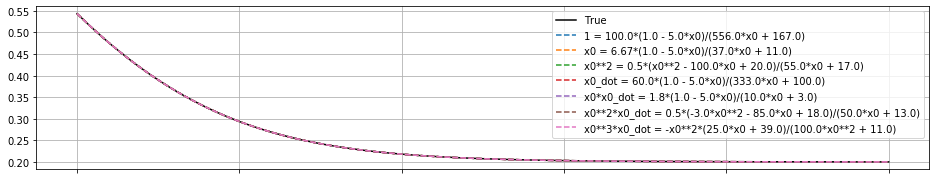

In [7]:
# Define the ODE symbol variables
t_sym = sp.symbols('t_sym')
x_sym = sp.symbols('x:%d' % r)
x_dot_sym = sp.symbols('x:%d_dot' % r)

# Need to format the above equations so that there are space between x0 * x0, x0 * x_dot0, and so on.
sym_equations_formatted = []
sym_equations_rounded_formatted = []
for i in range(nfeatures):
    for j in range(r):
        # Overkill to make sure all the x0, x1, etc. get replaced
        temp_string = str(sym_equations[i]).replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_string = temp_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_string = temp_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_string = temp_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_rounded_string = str(sym_equations_rounded[i]).replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_rounded_string = temp_rounded_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_rounded_string = temp_rounded_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_rounded_string = temp_rounded_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        sym_equations_formatted.append(temp_string)
        sym_equations_rounded_formatted.append(temp_rounded_string)

# Now that the equations are mathematically formatted, solve for x_dot0 in the algebraic equation
sym_equations_simplified = []
sym_equations_rounded_simplified = []
for i in range(nfeatures):
    sym_equations_simplified.append(sp.solve(
        sp.Add(
            sp.sympify(sym_equations_formatted)[i][0], 
            - sp.sympify(features_formatted[i])), 
        x_dot_sym))
    rounded = sp.solve(
        sp.Add(
            sp.sympify(sym_equations_rounded_formatted)[i][0], 
            - sp.sympify(features_formatted[i])), 
        x_dot_sym)
    if len(rounded) != 0:
        rounded_temp = rounded[0]
        for a in sp.preorder_traversal(rounded):
            if isinstance(a, sp.Float):
                rounded_temp = rounded_temp.subs(a, round(a, 2))
        sym_equations_rounded_simplified.append(rounded_temp)
    else:
        sym_equations_rounded_simplified.append([])

# Plot the results for each of the models
plt.figure(figsize=(16, 3))
x0_test = np.random.rand(1)
x_test = odeint(enzyme, x0_test, t)
plt.plot(t, x_test, color='k', linestyle='solid', label='True')
for i in range(nfeatures):
    ax = plt.gca()
    if i != nfeatures - 1:
        ax.set_xticklabels([])
    if len(sym_equations_simplified[i]) != 0:
        ODE_Func = sp.lambdify([x_sym, t_sym], sym_equations_simplified[i][0])

        # Now simulate the system we identified
        x_test_sim = odeint(ODE_Func, x0_test, t)
        if np.linalg.norm(x_test_sim) < 1e3 and sym_equations_rounded_simplified[i] != 0:
            plt.plot(t, x_test_sim, linestyle='dashed',
                     label=str(sp.sympify(features_formatted[i])
                              ) + ' = ' + str(
                         sym_equations_rounded_simplified[i]))
plt.grid(True)
plt.legend(fontsize=10)

### We will now try a 2D example, the bacterial competence system (Mangan et al. 2016)
$$ \dot{x} = a_1 + a_2x^2 / (a_3 + x^2) - x / (1 + x + y) $$
$$ \dot{y} = b_1 / (1 + b_2 x^5) - y / (1 + x + y) $$
with $a_1=0.004$, $a_2=0.07$, $a_3=0.04$, $b_1=0.82$, $b_2=1854.5$. Note that multi-variable SymPy will require some changes, and multi-variable SINDy-PI typically requires many trajectories to correctly identify models.

In [8]:
# define parameters
r = 2
dt = 0.02
T = 20
t_train = np.arange(0, T + dt, dt)

# Typically need at least 20-40 trajectories for a decent model.
# Note that this can be fairly time-consuming. 
n_trajectories = 40
x_train_multi = []
t_train_multi = []
for i in range(n_trajectories):
    x0 = np.random.rand(2)
    x_train_multi.append(odeint(bacterial, x0, t_train))
    t_train_multi.append(t_train[1:-1])

# Initialize custom SINDy library up to sixth order polynomials
x_library_functions = [lambda x:1, lambda x:x, lambda x, y:x * y, lambda x:x ** 2, 
                       lambda x, y, z:x * y * z, lambda x, y: x * y ** 2, lambda x: x ** 3,
                       lambda x, y, z, w: x * y * z * w, lambda x, y, z:x * y * z ** 2,
                       lambda x, y:x * y ** 3, lambda x:x ** 4, lambda x:x ** 5, lambda x:x ** 6]
x_dot_library_functions = [lambda x:1, lambda x:x]
        
library_function_names = [lambda x:'', lambda x:x, lambda x, y: x + y, lambda x:x + x, 
                          lambda x, y, z:x + y + z, lambda x, y: x + y + y, lambda x: x + x + x,
                          lambda x, y, z, w: x + y + z + w, lambda x, y, z:x + y + z + z,
                          lambda x, y:x + y + y + y, lambda x:x + x + x + x, 
                          lambda x:x + x + x + x + x, lambda x:x + x + x + x + x + x, 
                          lambda x:'', lambda x:x] 

# Get the indices of the equations for x0_dot and x1_dot
lib = ps.SINDyPILibrary(library_functions=x_library_functions, 
                        x_dot_library_functions=x_dot_library_functions,
                        t=t_train,
                        function_names=library_function_names,
                        ).fit(np.asarray(x_train_multi)[0, :, :])
lib.transform(np.asarray(x_train_multi)[0, :, :])
features = np.asarray(lib.get_feature_names())
ind1 = np.ravel(np.where(features == "x0_dot"))[0]
ind2 = np.ravel(np.where(features == "x1_dot"))[0]

# Need to flatten t_train_multi before passing time base to SINDyPILibrary
sindy_library = ps.SINDyPILibrary(library_functions=x_library_functions, 
                                  x_dot_library_functions=x_dot_library_functions,
                                  t=np.ravel(np.asarray(t_train_multi)),
                                  function_names=library_function_names,
                                  )

# Note, using model_subset (list of indices) to only compute two of the fits
sindy_opt = ps.SINDyPI(threshold=1e-2, tol=1e-5, 
                       thresholder="l1", max_iter=20000,
                       model_subset=[ind1, ind2],
                       )
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train_multi, t=dt, multiple_trajectories=True)
model.print()

 = 0.000
x0 = 0.000
x1 = 0.000
x0x1 = 0.000
x0x0 = 0.000
x1x1 = 0.000
x0x1x1 = 0.000
x0x0x0 = 0.000
x1x1x1 = 0.000
x0x1x1x1 = 0.000
x0x0x0x0 = 0.000
x1x1x1x1 = 0.000
x0x0x0x0x0 = 0.000
x1x1x1x1x1 = 0.000
x0x0x0x0x0x0 = 0.000
x1x1x1x1x1x1 = 0.000
x0_dot = -0.072  + -0.054 x0 + 0.148 x1 + -0.068 x0x1 + 0.307 x0x0 + -0.094 x1x1 + 0.029 x1x1x1 + 0.002 x0x1x1x1 + -0.001 x1x1x1x1 + -0.170 x0x0x0x0x0 + -0.002 x1x1x1x1x1 + 2.557 x0x0_dot + 0.516 x1x0_dot + -1.531 x0x0x0_dot + -0.098 x1x1x1x0_dot + -0.033 x0x1x1x1x0_dot + 0.003 x1x1x1x1x1x0_dot + 0.001 x1x1x1x1x1x1x0_dot + 0.046 x1_dot + -0.173 x0x1_dot + -0.024 x1x1_dot + -0.049 x1x1x1_dot + 0.073 x0x1x1x1_dot + -0.112 x0x0x0x1_dot + 0.055 x0x1x1x1x1_dot + 0.007 x1x1x1x1x1_dot + -0.005 x1x1x1x1x1x1_dot + -0.030 x0x0x0x0x0x0x1_dot + 0.001 x1x1x1x1x1x1x1_dot
x0x0_dot = 0.000
x1x0_dot = 0.000
x0x1x0_dot = 0.000
x0x0x0_dot = 0.000
x1x1x0_dot = 0.000
x0x1x1x0_dot = 0.000
x0x0x0x0_dot = 0.000
x1x1x1x0_dot = 0.000
x0x1x1x1x0_dot = 0.000
x0x0x0x0x0_do

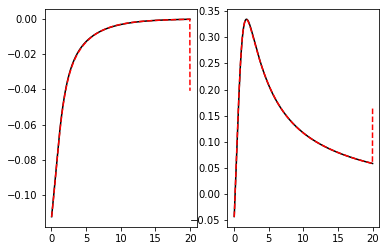

In [9]:
# Plot the fit of the derivative
x_train = np.asarray(x_train_multi)[0, :, :]
x_dot_train = model.differentiate(x_train, t_train)
x_dot_train_pred = sindy_opt.Theta[:len(t_train) - 2, :] @ sindy_opt.coef_.T
plt.figure()
inds = [ind1, ind2]
for i in range(r):
    plt.subplot(1, r, i + 1)
    plt.plot(t_train, x_dot_train[:, i], 'k')
    plt.plot(t_train[1:-1], x_dot_train_pred[:, inds[i]], 'r--')

In [10]:
# Repeat formatting the feature names and building the symbolic equations
features = model.get_feature_names()
nfeatures = len(features)
features[0] = '1'
features_copy = list(np.copy(features))
nfeatures = len(features)
features_formatted = []
# Need to put multiplication between terms for sympy
for i in range(nfeatures):
    for j in range(r):
        # Overkill to make sure all the x0, x1, etc. get replaced
        temp_string = features[i].replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_string = temp_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_string = temp_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_string = temp_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        features[i] = temp_string
    features_formatted.append(temp_string)
features = features_copy
print(features)
print(features_formatted)

coefs = model.coefficients()
sym_features = [sp.symbols(feature) for feature in features]
sym_theta = [sp.symbols(feature) for feature in features]
sym_equations = []
sym_equations_rounded = []
for i in range(nfeatures):
    if np.any(np.around(coefs[i], 2) != 0.0):
        sym_equation = sp.solve(sp.Eq(sym_theta[i], 
                                            sym_theta @ np.around(coefs[i], 10)), 
                                      sym_features[i])
        sym_equations.append(sym_equation)
        sym_equation_rounded = sp.solve(sp.Eq(sym_theta[i], 
                                            sym_theta @ np.around(coefs[i], 2)), 
                                      sym_features[i])
        sym_equations_rounded.append(sym_equation_rounded)
        print(sym_theta[i], ' = ', sym_equation_rounded[0])

['1', 'x0', 'x1', 'x0x1', 'x0x0', 'x1x1', 'x0x1x1', 'x0x0x0', 'x1x1x1', 'x0x1x1x1', 'x0x0x0x0', 'x1x1x1x1', 'x0x0x0x0x0', 'x1x1x1x1x1', 'x0x0x0x0x0x0', 'x1x1x1x1x1x1', 'x0_dot', 'x0x0_dot', 'x1x0_dot', 'x0x1x0_dot', 'x0x0x0_dot', 'x1x1x0_dot', 'x0x1x1x0_dot', 'x0x0x0x0_dot', 'x1x1x1x0_dot', 'x0x1x1x1x0_dot', 'x0x0x0x0x0_dot', 'x1x1x1x1x0_dot', 'x0x0x0x0x0x0_dot', 'x1x1x1x1x1x0_dot', 'x0x0x0x0x0x0x0_dot', 'x1x1x1x1x1x1x0_dot', 'x1_dot', 'x0x1_dot', 'x1x1_dot', 'x0x1x1_dot', 'x0x0x1_dot', 'x1x1x1_dot', 'x0x1x1x1_dot', 'x0x0x0x1_dot', 'x1x1x1x1_dot', 'x0x1x1x1x1_dot', 'x0x0x0x0x1_dot', 'x1x1x1x1x1_dot', 'x0x0x0x0x0x1_dot', 'x1x1x1x1x1x1_dot', 'x0x0x0x0x0x0x1_dot', 'x1x1x1x1x1x1x1_dot']
['1', 'x0', 'x1', 'x0 * x1', 'x0 * x0', 'x1 * x1', 'x0 * x1 * x1', 'x0 * x0 * x0', 'x1 * x1 * x1', 'x0 * x1 * x1 * x1', 'x0 * x0 * x0 * x0', 'x1 * x1 * x1 * x1', 'x0 * x0 * x0 * x0 * x0', 'x1 * x1 * x1 * x1 * x1', 'x0 * x0 * x0 * x0 * x0 * x0', 'x1 * x1 * x1 * x1 * x1 * x1', 'x0_dot', 'x0 * x0_dot', 'x1 * x

Solved for xdot equations =  {x0_dot: (-(4180000000836.0*x0**6 + 8.5163735667033e+18*x0**5 - 1455000000291.0*x0**4 - 2740000000548.0*x0**3 - 1.53373720130675e+19*x0**2 - 1.07189470021438e+17*x0*x1**3 + 2120000000424.0*x0*x1**2 + 3.39711817567943e+18*x0*x1 + 2.695010680539e+18*x0 - 1.24270550024854e+16*x1**6 + 8.1441145016288e+16*x1**5 + 4.17360350083472e+16*x1**4 - 1.42722309528545e+18*x1**3 + 4.71483426594297e+18*x1**2 - 7.41081177648215e+18*x1 + 3.58677007571736e+18)*(1.53243115210621e+18*x0**6 + 2340000018486.0*x0**5 + 2390000018881.0*x0**4 - 9.52183929922253e+19*x0**3 + 4.42158456633052e+20*x0**2 + 2.88320714777734e+19*x0*x1**3 - 3.16496499200322e+20*x0*x1**2 + 4.0387720441063e+20*x0*x1 - 3.36731245290177e+20*x0 + 5.17795694090586e+18*x1**6 - 4.89684970868511e+19*x1**5 + 1.76291323092701e+20*x1**4 - 3.38568714594693e+20*x1**3 + 4.20242749899918e+20*x1**2 - 2.79419564387415e+20*x1 + 1.0e+20) - 2.0*(7.4890104014978e+17*x0**6 + 15000000003.0*x0**5 + 160000000032.0*x0**4 + 2.8037911930

/Users/alankaptanoglu/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


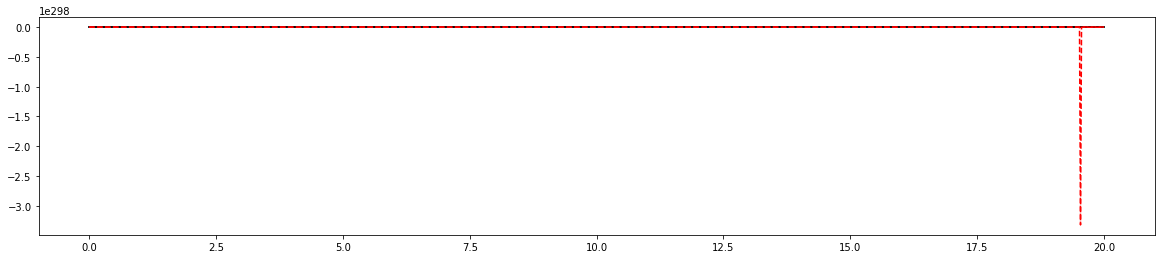

In [11]:
# Define the ODE symbol variables
t_sym = sp.symbols('t_sym')
x_sym = sp.symbols('x:%d' % r)
x_dot_sym = sp.symbols('x:%d_dot' % r)

# Need to format the above equations so that there are space between x0 * x0, x0 * x_dot0, and so on.
sym_equations_formatted = []
for i in range(len(sym_equations)):
    for j in range(r):
        # Overkill to make sure all the x0, x1, etc. get replaced
        temp_string = str(sym_equations[i]).replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_string = temp_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_string = temp_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_string = temp_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        sym_equations[i] = temp_string
    sym_equations_formatted.append(temp_string)

# IMPORTANT change for multi-variable implicit equations:
# Now that the equations are mathematically formatted, 
# solve for x0_dot and x1_dot in the algebraic equation.
# Have two unknowns, (x0_dot, x1_dot), 
# so need to solve using two of ANY of the equations,
# but for simplicity we choose the equations for x0_dot and x1_dot
sym_equations_simplified = sp.solve(
    (sp.Add(
        sp.sympify(sym_equations_formatted)[0][0], 
        - sp.sympify(features_formatted[ind1])), 
    sp.Add(
        sp.sympify(sym_equations_formatted)[1][0], 
        - sp.sympify(features_formatted[ind2]))),
    x_dot_sym)
print('Solved for xdot equations = ', sym_equations_simplified)

# Plot the results for each of the models
plt.figure(figsize=(20, 4))
x0_test = [0.5, 0.1]
t_test = t_train
x_test = odeint(bacterial, x0_test, t_test)
plt.plot(t_test, x_test, color='k',linestyle='solid')

# Not the cleanest notation for multiple variables, but it works
ODE_Func = sp.lambdify([x_sym, t_sym], 
                       [sym_equations_simplified[x_dot_sym[0]], 
                        sym_equations_simplified[x_dot_sym[1]]])

# Now simulate the system we identified
x_test_sim = odeint(ODE_Func, x0_test, t_test)
plt.plot(t_test, x_test_sim, color='r', linestyle='dashed')


### Although the model performs well on the test trajectory the final model form looks pretty crazy... this is mostly because of the SymPy solve function, which struggles with getting the correct numerical precisions on each coefficient. 

### Okay, we have illustrated that we can:
### 1. Use SINDyPI to derive implicit equations of motion
### 2. Convert to symbolic equations of motion, and use this to solve for x_dot
### 3. Plug this into an ODE solver and integrate the new equations of motions for x_dot.
### However, for some systems, we may want to be able to integrate and manipulate fully differential algebraic equations (DAEs) without trying to solve for x_dot. Unfortunately, this requires the Julia coding package, which can be obtained online easily.
To install the dependencies on my computer, at a terminal, I need to do: <br>
julia  (enters the julia console) <br>
import Pkg <br>
Pkg.add("PyCall") <br>
Pkg.add("DiffEqBase") <br>
Pkg.add("DifferentialEquations") <br>
exit() <br>

### In this case we will:
### 1. Import the diffeqpy package and install it and its dependencies. This requires the coding language Julia to be installed on your computer.
### 2. Use SINDyPI to derive implicit equations of motion
### 3. Convert to symbolic equations of motion
### 3. Plug this into a general DAE solver and integrate the new equations of motions for x_dot.

In [12]:
from julia.api import Julia
jl = Julia(compiled_modules=False)
from diffeqpy import de

# This can take a few minutes to install!!
import diffeqpy
# import sys
# print(sys.path)
diffeqpy.install()
from diffeqpy import de

FileNotFoundError: [Errno 2] No such file or directory: 'julia': 'julia'

In [ ]:
# Use previously identified models, the system ID part is unchanged

# Define the time and p symbols, these are dummy variables
t_sym=sp.symbols('t_sym')
p_sym=sp.symbols('p_sym')
x_sym = sp.symbols('x:%d' % r)
x_dot_sym = sp.symbols('x:%d_dot' % r)

# lambdify the DAE, not solving for x_dot first!
SINDy_model=sp.lambdify([x_dot_sym, x_sym, p_sym, t_sym],  
                         [sym_equations_formatted[x_dot_sym[0]], 
                          sym_equations_formatted[x_dot_sym[1]]])

# Integrate the DAE with diffeqpy and plot against true test trajectory
plt.figure()
plt.plot(t, x_test, 'k')

dx0 = [0.05, 0.1]
tspan = (t_test[0], t_test[-1])
differential_vars = [True, True]
prob = de.DAEProblem(SINDy_model, dx0, x0_test, tspan, differential_vars=differential_vars)
sol = de.solve(prob)
plt.plot(sol.t, sol.u, 'r--')
plt.grid(True)

### Last example: 4D pendulum on a cart equations,
$$\frac{d}{dt}\phi = \dot{\phi}$$
$$\frac{d}{dt}s = \dot{s}$$
$$\frac{d}{dt}\dot{\phi} = -\frac{F\cos(\phi) - (M + m)g\sin(\phi) + mL\cos(\phi)\sin(\phi)\dot{\phi}^2}{L(M + m\sin^2(\phi))}$$
$$\frac{d}{dt}\dot{s} = \frac{F - mg\cos(\phi)\sin(\phi) + mL\sin(\phi)\dot{\phi}^2}{M + m\sin^2(\phi)}$$


In [13]:
# define parameters
r = 4
dt = 0.001
T = 20
t_train = np.arange(0, T + dt, dt)

# no control inputs for simplicity
x0 = [0.3, -0.2, 1.0, 0.4]
x_train = odeint(pendulum_on_cart, x0, t_train, args=(1, 1, 1, 0, 9.81))

# define hyperparameters
threshold = 1e-2

x_library_functions = [lambda x:1, lambda x:x, lambda x:sin(x),
                       lambda x: sin(x) * sin(x), lambda x: sin(x) * cos(x)]
x_dot_library_functions = [lambda x:1, lambda x:x, lambda x:x ** 2]
        
library_function_names = [lambda x:'', lambda x:x, lambda x: 'sin(' + x + ')',
                          lambda x: 'sin(' + x + ')' + 'sin(' + x + ')', 
                          lambda x: 'sin(' + x + ')' + 'cos(' + x + ')',
                          lambda x:'', lambda x:x, lambda x: x + x] 

# Get the indices of the equations for x0_dot, ..., x3_dot
lib = ps.SINDyPILibrary(library_functions=x_library_functions, 
                        x_dot_library_functions=x_dot_library_functions,
                        t=t_train,
                        function_names=library_function_names,
                        ).fit(x_train) 
lib.transform(x_train)
features = np.asarray(lib.get_feature_names())
ind1 = np.ravel(np.where(features == "x0_dot"))[0]
ind2 = np.ravel(np.where(features == "x1_dot"))[0]
ind3 = np.ravel(np.where(features == "x2_dot"))[0]
ind4 = np.ravel(np.where(features == "x3_dot"))[0]

sindy_library = ps.SINDyPILibrary(library_functions=x_library_functions, 
                                  x_dot_library_functions=x_dot_library_functions,
                                  t=t_train[1:-1],
                                  function_names=library_function_names,
                                  )

# Column normalization essential here because phi and s have different units
# and problem is very ill-conditioned
sindy_opt = ps.SINDyPI(threshold=threshold, tol=1e-6, 
                       thresholder="l1", max_iter=20000,
                       model_subset=[ind1, ind2, ind3, ind4],
                       normalize_columns=True)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=dt)
model.print()

 = 0.000
x0 = 0.000
x1 = 0.000
x2 = 0.000
x3 = 0.000
sin(x0) = 0.000
sin(x1) = 0.000
sin(x2) = 0.000
sin(x3) = 0.000
sin(x0)sin(x0) = 0.000
sin(x1)sin(x1) = 0.000
sin(x2)sin(x2) = 0.000
sin(x3)sin(x3) = 0.000
sin(x0)cos(x0) = 0.000
sin(x1)cos(x1) = 0.000
sin(x2)cos(x2) = 0.000
sin(x3)cos(x3) = 0.000
x0_dot = 0.995 x2
x0x0_dot = 0.000
x1x0_dot = 0.000
x2x0_dot = 0.000
x3x0_dot = 0.000
sin(x0)x0_dot = 0.000
sin(x1)x0_dot = 0.000
sin(x2)x0_dot = 0.000
sin(x3)x0_dot = 0.000
sin(x0)sin(x0)x0_dot = 0.000
sin(x1)sin(x1)x0_dot = 0.000
sin(x2)sin(x2)x0_dot = 0.000
sin(x3)sin(x3)x0_dot = 0.000
sin(x0)cos(x0)x0_dot = 0.000
sin(x1)cos(x1)x0_dot = 0.000
sin(x2)cos(x2)x0_dot = 0.000
sin(x3)cos(x3)x0_dot = 0.000
x1_dot = 0.995 x3
x0x1_dot = 0.000
x1x1_dot = 0.000
x2x1_dot = 0.000
x3x1_dot = 0.000
sin(x0)x1_dot = 0.000
sin(x1)x1_dot = 0.000
sin(x2)x1_dot = 0.000
sin(x3)x1_dot = 0.000
sin(x0)sin(x0)x1_dot = 0.000
sin(x1)sin(x1)x1_dot = 0.000
sin(x2)sin(x2)x1_dot = 0.000
sin(x3)sin(x3)x1_dot = 0.000
sin

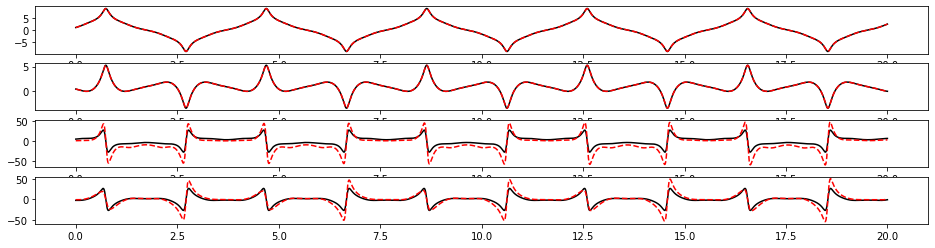

In [14]:
# Plot the fit of the derivative
x_dot_train = model.differentiate(x_train, t_train)
x_dot_train_pred = model.predict(x_train[1:-1, :]) 
reg = np.linalg.norm(sindy_opt.Theta, 2, axis=0)
x_dot_train_pred = sindy_opt.Theta @ sindy_opt.coef_.T

plt.figure(figsize=(16, 4))
inds = [ind1, ind2, ind3, ind4]
for i in range(r):
    plt.subplot(r, 1, i + 1)
    plt.plot(t_train, x_dot_train[:, i], 'k')
    plt.plot(t_train[1:-1], x_dot_train_pred[:, inds[i]], 'r--')

In [16]:
from sympy import sin, cos
nfeatures = len(features)
features[0] = '1'
features_copy = list(np.copy(features))
nfeatures = len(features)
features_formatted = []
# Need to put multiplication between terms for sympy
for i in range(nfeatures):
    for j in range(r):
        # Overkill to make sure all the x0, x1, etc. get replaced
        temp_string = features[i].replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_string = temp_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_string = temp_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_string = temp_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_string = temp_string.replace('tx' + str(j), 't * x' + str(j))
        temp_string = temp_string.replace('tx' + str(j), 't * x' + str(j))
        temp_string = temp_string.replace(')x', ') * x')
        temp_string = temp_string.replace(')c', ') * c')
        temp_string = temp_string.replace(')s', ') * s')

        features[i] = temp_string
    features_formatted.append(temp_string)
features = features_copy
# print(features)
print(features_formatted)

coefs = model.coefficients()
sym_features = [sp.symbols(feature) for feature in features]
sym_theta = [sp.symbols(feature) for feature in features]
sym_equations = []
sym_equations_rounded = []
for i in range(nfeatures):
    if np.any(np.around(coefs[i], 2) != 0.0):
        sym_equation = sp.solve(sp.Eq(sym_theta[i], 
                                            sym_theta @ np.around(coefs[i], 10)), 
                                      sym_features[i])
        sym_equations.append(sym_equation)
        sym_equation_rounded = sp.solve(sp.Eq(sym_theta[i], 
                                            sym_theta @ np.around(coefs[i], 2)), 
                                      sym_features[i])
        sym_equations_rounded.append(sym_equation_rounded)
        print(sym_theta[i], ' = ', sym_equation_rounded[0])

['1', 'x0', 'x1', 'x2', 'x3', 'sin(x0)', 'sin(x1)', 'sin(x2)', 'sin(x3)', 'sin(x0) * sin(x0)', 'sin(x1) * sin(x1)', 'sin(x2) * sin(x2)', 'sin(x3) * sin(x3)', 'sin(x0) * cos(x0)', 'sin(x1) * cos(x1)', 'sin(x2) * cos(x2)', 'sin(x3) * cos(x3)', 'x0_dot', 'x0 * x0_dot', 'x1 * x0_dot', 'x2 * x0_dot', 'x3 * x0_dot', 'sin(x0) * x0_dot', 'sin(x1) * x0_dot', 'sin(x2) * x0_dot', 'sin(x3) * x0_dot', 'sin(x0) * sin(x0) * x0_dot', 'sin(x1) * sin(x1) * x0_dot', 'sin(x2) * sin(x2) * x0_dot', 'sin(x3) * sin(x3) * x0_dot', 'sin(x0) * cos(x0) * x0_dot', 'sin(x1) * cos(x1) * x0_dot', 'sin(x2) * cos(x2) * x0_dot', 'sin(x3) * cos(x3) * x0_dot', 'x1_dot', 'x0 * x1_dot', 'x1 * x1_dot', 'x2 * x1_dot', 'x3 * x1_dot', 'sin(x0) * x1_dot', 'sin(x1) * x1_dot', 'sin(x2) * x1_dot', 'sin(x3) * x1_dot', 'sin(x0) * sin(x0) * x1_dot', 'sin(x1) * sin(x1) * x1_dot', 'sin(x2) * sin(x2) * x1_dot', 'sin(x3) * sin(x3) * x1_dot', 'sin(x0) * cos(x0) * x1_dot', 'sin(x1) * cos(x1) * x1_dot', 'sin(x2) * cos(x2) * x1_dot', 'sin(x3)

KeyboardInterrupt: 

In [ ]:
# Define the ODE symbol variables
t_sym = sp.symbols('t_sym')
x_sym = sp.symbols('x:%d' % r)
x_dot_sym = sp.symbols('x:%d_dot' % r)

# Need to format the above equations so that there are space between x0 * x0, x0 * x_dot0, and so on.
sym_equations_formatted = []
for i in range(len(sym_equations)):
    for j in range(r):
        # Overkill to make sure all the x0, x1, etc. get replaced
        temp_string = str(sym_equations[i]).replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_string = temp_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_string = temp_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_string = temp_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_string = temp_string.replace('tx' + str(j), 't * x' + str(j))
        temp_string = temp_string.replace('tx' + str(j), 't * x' + str(j))
        temp_string = temp_string.replace(')x', ') * x')
        temp_string = temp_string.replace(')c', ') * c')
        temp_string = temp_string.replace(')s', ') * s')
        sym_equations[i] = temp_string
    sym_equations_formatted.append(temp_string)

# Now that the equations are mathematically formatted, solve for x0_dot and x1_dot in the algebraic equation
# Have four unknowns, (x0_dot, x1_dot, x2_dot, x3_dot), so need to solve using four of the equations
sym_equations_simplified = sp.solve(
    (sp.Add(
        sp.sympify(sym_equations_formatted)[0][0], 
        - sp.sympify(features_formatted[ind1])), 
    sp.Add(
        sp.sympify(sym_equations_formatted)[1][0], 
        - sp.sympify(features_formatted[ind2])), 
    sp.Add(
        sp.sympify(sym_equations_formatted)[2][0], 
        - sp.sympify(features_formatted[ind3]))
    sp.Add(
        sp.sympify(sym_equations_formatted)[3][0], 
        - sp.sympify(features_formatted[ind4]))),
    x_dot_sym)
print('Solved for xdot equations = ', sym_equations_simplified)

# Plot the results for each of the models
plt.figure(figsize=(20, 4))

x0_test = [np.pi, 0, 0, 0]
t_test = t_train
x_test = odeint(pendulum_on_cart, x0_test, t_test, args=(1, 1, 1, 0, 9.81))
plt.plot(t_test, x_test, color='k',linestyle='solid')

# Not the cleanest notation for multiple variables but it works
ODE_Func = sp.lambdify([x_sym, t_sym], 
                       [sym_equations_simplified[x_dot_sym[0]], 
                        sym_equations_simplified[x_dot_sym[1]],
                        sym_equations_simplified[x_dot_sym[2]],
                        sym_equations_simplified[x_dot_sym[3]]])

# Now simulate the system we identified
x_test_sim = odeint(ODE_Func, x0_test, t_test)
plt.plot(t_test, x_test_sim, color='r', linestyle='dashed')